In [1]:

import tensorflow as tf 
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# This is for the notebook to generate inline matplotlib 
# charts rather than to open a new window every time: 
%matplotlib inline
try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print("TensorFlow's version : 1.0 (or more)")
except: 
    print("TensorFlow's version : 0.12")


TensorFlow's version : 1.0 (or more)


In [46]:
def generate_data(batch_size, input_seq_length , output_seq_length):


    batch_x = []
    batch_y = []
    for _ in range(batch_size):
        rand = random.random() * 2 * math.pi

        sig1 = np.sin(np.linspace(0.0 * math.pi + rand,
                                  3.0 * math.pi + rand, input_seq_length+output_seq_length))
        sig2 = np.cos(np.linspace(0.0 * math.pi + rand,
                                  3.0 * math.pi + rand, input_seq_length+output_seq_length))
        
        x1 = sig1[:input_seq_length]
        y1 = sig1[input_seq_length:]

        x_ = np.array([x1])
        y_ = np.array([y1])
        
        x_, y_ = x_.T, y_.T


        batch_x.append(x_)
        batch_y.append(y_)

    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    # shape: (batch_size, seq_length, output_dim)

    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    # shape: (seq_length, batch_size, output_dim)
 
    
    return batch_x, batch_y

In [47]:
hidden_dim = 12  # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 2  # Number of stacked recurrent cells, on the neural depth axis. 
input_seq_length  = 10
output_seq_length = 10


# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
nb_iters = 150  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

# Internal neural network parameters

batch_size = 5 

input_dim = 1  
output_dim = 1  



In [48]:

tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):

    # Encoder: inputs
    
    enc_inp = []

    for t in range(input_seq_length):
        enc_inp.append(tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t)))

    # Decoder: expected outputs
    expected_sparse_output = []
    for t in range(output_seq_length):
        expected_sparse_output.append(tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t)))
   

    
    # Give a "GO" token to the decoder. 
    # You might want to revise what is the appended value "+ enc_inp[:-1]". 
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="end") ] + enc_inp[1:output_seq_length]
    #for t in range(output_seq_length):
    #    dec_inp.append(tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t)))
    #print(len(dec_inp))

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # For reshaping the input and output dimensions of the seq2seq RNN: 
    w_in = tf.Variable(tf.random_normal([input_dim, hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
    
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in) for i in enc_inp]
    
    # Here, the encoder and the decoder uses the same cell, HOWEVER,
    # the weights aren't shared among the encoder and decoder, we have two
    # sets of weights created under the hood according to that function's def. 
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )
    
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    # Final outputs: with linear rescaling similar to batch norm, 
    # but without the "norm" part of batch normalization hehe.
    '''
    for i in range(len(dec_outputs)-predict_length,len(dec_outputs)):
        print(i)
        reshaped_outputs = [output_scale_factor*(tf.matmul(dec_outputs[i], w_out) + b_out) ]
    '''
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]

10


In [49]:

# Training loss and optimizer

with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        
    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
            
    loss = output_loss + lambda_l2_reg * reg_loss

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)


In [50]:

def train_batch(batch_size):
    """
    Training step that optimizes the weights 
    provided some batch_size X and Y examples from the dataset. 
    """
    X, Y = generate_data(batch_size = batch_size, input_seq_length = input_seq_length , output_seq_length = output_seq_length)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

def test_batch(batch_size):
    """
    Test step, does NOT optimizes. Weights are frozen by not
    doing sess.run on the train_op. 
    """
    X, Y = generate_data(batch_size = batch_size, input_seq_length = input_seq_length , output_seq_length = output_seq_length)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]


# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    
    if t % 10 == 0: 
        # Tester
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))


Step 0/150, train loss: 144.7630157470703, 	TEST loss: 57.062400817871094
Step 10/150, train loss: 2.9038188457489014, 	TEST loss: 3.245819568634033
Step 20/150, train loss: 1.1607656478881836, 	TEST loss: 1.0203324556350708
Step 30/150, train loss: 0.6231345534324646, 	TEST loss: 0.6369386911392212
Step 40/150, train loss: 0.5187870860099792, 	TEST loss: 0.5340925455093384
Step 50/150, train loss: 0.4968131184577942, 	TEST loss: 0.49109193682670593
Step 60/150, train loss: 0.9339718818664551, 	TEST loss: 1.1336315870285034
Step 70/150, train loss: 0.5155786275863647, 	TEST loss: 1.017760992050171
Step 80/150, train loss: 0.7342240214347839, 	TEST loss: 1.7136361598968506
Step 90/150, train loss: 0.7412618398666382, 	TEST loss: 1.38473641872406
Step 100/150, train loss: 0.61387038230896, 	TEST loss: 1.0509577989578247
Step 110/150, train loss: 0.5037808418273926, 	TEST loss: 0.41423535346984863
Step 120/150, train loss: 0.3930704593658447, 	TEST loss: 0.3844374418258667
Step 130/150, t

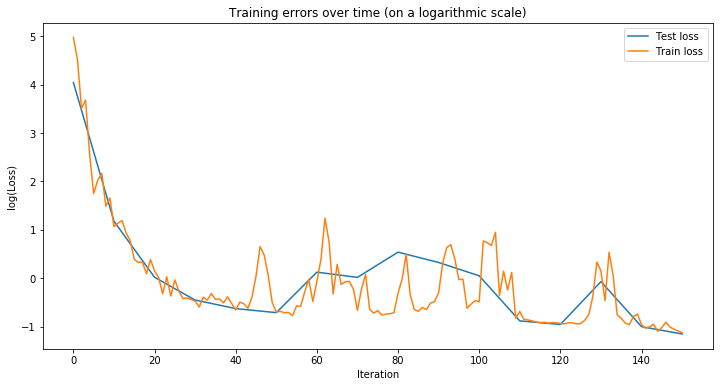

In [51]:

# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss"
)
plt.plot(
    np.log(train_losses), 
    label="Train loss"
)
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()


(10, 5, 1)


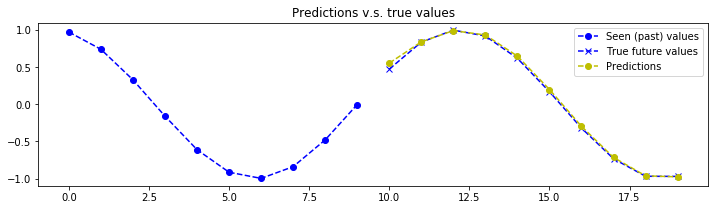

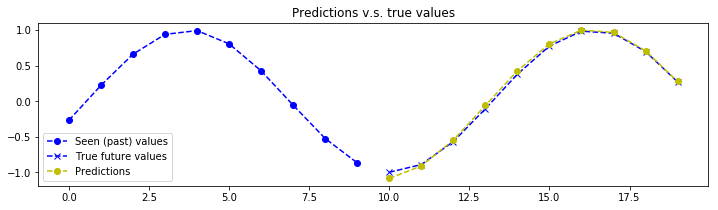

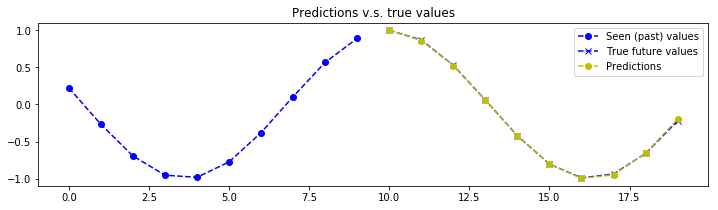

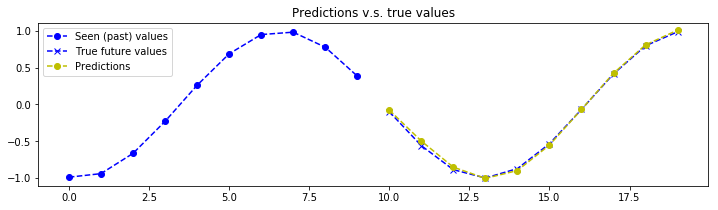

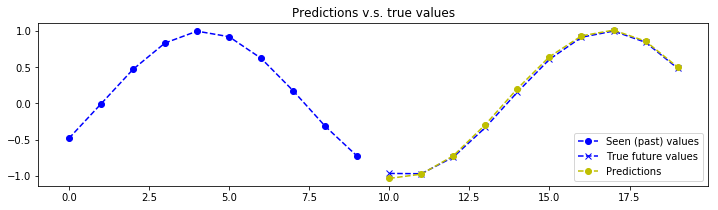

In [52]:
# Test
test_case = 5


X, Y = generate_data(batch_size = test_case, input_seq_length = input_seq_length, output_seq_length = output_seq_length)
feed_dict = {enc_inp[t]: X[t] for t in range(input_seq_length)}
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
print(outputs.shape)
for j in range(test_case): 
    plt.figure(figsize=(12, 3))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[:,j,k]
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

